# Vision Lab SS2023 Final Report
#### Topic: Human Pose Forecasting with Spatio-Temporal Transformers
#### Authors: Luis Denninger, Leon Herbrik

## Table of Contents
1. [Imports/Utilities](#imports)
2. [Project Overview](#proj_overview)

    2.1. [Installation](#installation)

    2.2. [Experiment Structure](#exp_structure)

    2.3. [Model Implementations](#model_impl)

    2.4. [Logging](#logging)

    2.5. [Training](#training)
    
    2.6. [Evaluation](#evaluation)

3. [Human3.6M Dataset Evaluation](#h36m_eval)

    3.1. [Local 3D Positions](#h36m_local)
    
    3.2. [Global 3D Positions](#h36m_global)

4. [AIS Dataset Evaluation](#ais_eval)

5. [Long Prediction Evaluation](#long_pred)

## Imports / Utilities <a class="anchor" id="imports"></a>

In [23]:
##-- Imports --##
import json
from IPython.display import HTML, display, clear_output
from PIL import Image

import src.utils as utils
import src.models as models
import src.data_utils as data_utils
import src.evaluation as evaluation
import src.visualization as visualization
from src import Session

##-- Utility Functions --##
def display_animation(animation):
    clear_output(wait=True)  # Remove the previous frame
    display(HTML(animation.to_jshtml()))

## Project Overview <a class="anchor" id="proj_overview"></a>

In this section we will give a detailed overview over the code base and how it can be used to easily run different experiments.
    
        .
        ├── ...
        ├── configurations                  # Configurations files
        ├── data                            # Dataset
        ├── experiments                     # Experiment directory
        ├── src                             # Python source files
        │   ├── data_utils                  # Functions and modules for data processing
        │   ├── evaluation                  # Functions and modules for the evaluation
        │   ├── models                      # Torch models used within the project
        │   ├── tests                       # Tests to demonstrate the correct behaviour
        │   ├── utils                       # Utility functions
        │   ├── visualization               # Visualization functions
        │   └── Session.py                  # Session encapsuling all training and evaluation
        ├── env.sh                          # Source file for the experiment environment
        ├── keep_exp.sh                     # script to add .gitignore files into empty folders in the experiment directory
        ├── run.py                          # General run file
        ├── train.py                        # Run a training
        ├── test.py                         # Test specific parts of the project
        ├── evaluate.py                     # Evaluate a trained model from the experiment directory
        ├── visualize.py                    # Produce visualizations using a trained model
        └── ...

### Installation <a class="anchor" id="installation"></a>

The complete project is implemented using the PyTorch library and complementary libraries using the PyTorch framework. We used Conda for our python environment using Python 3.11. <br/>
To install the PyTorch library please follow: https://pytorch.org/. Here is an example command:
```
    conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia
```
Next, we can install the other libraries using pip:
```
    pip install matplotlib plotly tqdm ipdb numpy 
```

### Experiment Structure <a class="anchor" id="exp_structure"></a>

The experiments are structured into experiment directories with multiple runs. <br/>
Here we have an example directory:
```
            .
        ├── ...
        ├── experiments                     # Experiment directory
        │   ├── example_experiment          # Example experiment
        │   │   ├── example_run             # Example run
        │   │   │   ├── checkpoints         # Directory holding the checkpoints made during training
        │   │   │   ├── logs                # Contains all logs written during training and evaluation
        │   │   │   ├── visualizations      # Contains all visualization made for evaluation
        │   │   │   ├── config.json         # Contains all configuration parameters for the model and training
        │   │   └── ...
        │   └── ...    
        └── ...       
```
To manage different experiments and runs, we use a small-scale managing tool. To enable all functions we need to first source the bash script `env.sh`.




#### Environment Management
To manage our experiments we use the functions provided in this: [src/utils/management.py](src/utils/management.py)

**Set an Experiment**: `setexp [run_name]` <br/>
**Set a Run**: `setrun [run_name]` <br/>
**Check Setup**: `setup` <br/>
**Synchronize Runs**: `sync_exp [username] [machine]`


In [24]:
# Experiment and run name
experiment_name = "example_experiment"
run_name = "example_run"
# Create new experiment and run
utils.create_experiment(experiment_name)
utils.create_run(experiment_name, run_name)

Experiment directory already exists
Run directory already exists


-1

#### Run Configurations
Our project aims at being as flexible as possible. All configuration parameters are defined through the `config.json` file. This allows complete control over the dataset, model architecture, training scheme and evaluation. An example config used for our final model can be found at: [configurations/final_config.json](configurations/final_config.json) <br/>

In [25]:
# Load a configuration file from the configurations directory
config = utils.load_config('final_config')
# Change config parameters for demonstration purposes
config['num_train_iterations'] = 200
config['num_eval_iterations'] = 100
config['num_epochs'] = 10
config['lr_scheduler']['max_iterations'] = 2000
config['lr_scheduler']['warmup'] = 0
# Save config to run directory and print it out
utils.save_config(config, experiment_name, run_name)
print(json.dumps(config, indent=4, sort_keys=True))

{
    "batch_size": 32,
    "checkpoint_frequency": 5,
    "data_augmentation": {
        "gaussian_noise_prob": 0.0,
        "gaussian_noise_std": 0.005,
        "joint_cutout_portion": [
            1,
            4
        ],
        "joint_cutout_prob": 0.0,
        "normalize": true,
        "reverse_prob": 0.0,
        "snp_noise_portion": [
            0.05,
            0.4
        ],
        "snp_noise_prob": 0.0,
        "timestep_cutout_portion": [
            1,
            4
        ],
        "timestep_cutout_prob": 0.0
    },
    "dataset": {
        "downsampling_factor": 2,
        "name": "h36m",
        "normalize_orientation": true,
        "reverse_prob": 0.5,
        "seed_length": 10,
        "spacing": 5,
        "target_length": 10,
        "test_size": 1000,
        "training_size": 1000,
        "validation_size": 1000
    },
    "evaluation": {
        "distribution_metrics": [],
        "exhaustive_evaluation": true,
        "frequency": 1,
        "metrics"

### Model Implementations <a class="anchor" id="model_impl"></a>

We implemented all models from scratch according to: https://arxiv.org/abs/2004.08692. <br/>
For some extended details we also considered the original implementation in Tensorflow V1 from: https://github.com/eth-ait/motion-transformer. 

The implemented PyTorch modules are structured in three stages.

**Attention**: At the lowest level we implemented a vanilla, spatial and temporal attention mechanism. The code can be found at: [src/models/attention.py](src/models/attention.py) 

**Transformer**: Next we implemented the used transformer blocks that implement the attention mechanism. This includes a vanilla, spatio-temporal and two sequential transformer blocks that were used for our experiments. The code can be found at: [src/models/transformer.py](src/models/transformer.py)

**Pose Predictor**: Finally, we implemented a pose predictor that can use different transformer blocks and architectures to auto-regressively predict poses. The code can be found at: [src/models/PosePredictor.py](src/models/PosePredictor.py)

**Additional Modules**: The positional encoding can be found in [src/models/positional_encoding.py](src/models/positional_encoding.py). Additional processing functions and modules are located at: [src/models/utils.py](src/models/utils.py)

In [26]:
model = models.getModel(config)
print(model)

PosePredictor(
  (joint_encoder): PointWiseLinear(in_features=3, out_features=64, num_points=16 bias=True)
  (positionalEncoding): PositionalEncodingSinusoidal()
  (inputDropout): Dropout(p=0.1, inplace=False)
  (attnBlocks): Sequential(
    (0): SpatioTemporalTransformer(
      emb_size=64, num_emb=16, temporal_heads=4, spatial_heads=4, temporal_dropout=0.1, spatial_dropout=0.1, ff_dropout=0.1
      (temporalAttention): TemporalAttention()
      (spatialAttention): SpatialAttention()
      (layerNorm): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (pointWiseFF): Sequential(
        (0): Linear(in_features=64, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=64, bias=True)
      )
      (temporalDropout): Dropout(p=0.1, inplace=False)
      (spatialDropout): Dropout(p=0.1, inplace=False)
      (ffDropout): Dropout(p=0.1, inplace=False)
    )
    (1): SpatioTemporalTransformer(
      emb_size=64, num_emb=16, temporal_heads=4

### Data <a class="anchor" id="data"></a>

Everything regarding datasets, data loading and data manipulation can be found in the directory: `src/data_utils`.

**Meta Information**: Meta information about the different datasets, skeleton structures that are used throughout this project can be found in [src/data_utils/meta_info.py](src/data_utils/meta_info.py)

**Dataset**: We implemented PyTorch datasets for the Human3.6M dataset and the AIS dataset. The code can be found at: [src/data_utils/data_loader.py](src/data_utils/data_loader.py).

**Data Loading**: All functions that read the data for the datasets from files and parse them to PyTorch tensor can be found at: [src/data_utils/data_loading.py](src/data_utils/data_loading.py)

**Data Manipulation**: All functions that were used to parse data to specific skeleton structures, normalize the data and compute 3D positions from the skeleton structure can be found at: [src/data_utils/skeleton_utils.py](src/data_utils/skeleton_utils.py)

**Transformations**: To transform between different joint representations, we adopted the conversion functions provided by PyTorch3D (https://github.com/facebookresearch/pytorch3d) and added missing functions for our use case. The code can be found at: [src/utils/transformations.py](src/utils/transformations.py)



In [27]:
dataset = data_utils.H36MDataset(
                                    actions=['walking'],
                                    seed_length=100,
                                    target_length=100,
                                    down_sampling_factor=2,
                                    stacked_hourglass=True,
                                    rot_representation="pos",
                                    normalize_orientation=True,
                                    sequence_spacing=0,
                                    return_label=False,
                                    is_train=True,
                                    debug=False
                                )

Loading Human3.6M data...


100%|██████████| 10/10 [00:00<00:00, 11.04it/s]


In [28]:

sequence = dataset[0]
animation = visualization.animate_pose_matplotlib(
                positions = (sequence.numpy(), sequence.numpy()),
                colors = ('g', 'g'),
                titles = ("Example Sequence","Example Sequence"),
                fig_title = "Dataset Example",
                parents = data_utils.SH_SKELETON_PARENTS,
                change_color_after_frame=(100,100),
                color_after_change='r',
                overlay=True,
                show_axis=False,
                fps=25,
                constant_limits=True,
                notebook=True
            )
display_animation(animation)

### Logging <a class="anchor" id="logging"></a>

To log the training and evaluation results we implemented a logger that handles the complete logging during training. The command line output is logged to a text file in the run directory: `logs/log.txt`. All other logs are kept online using the logging framework WandB. The logger can be found at: [src/utils/logging.py](src/utils/logging.py)

The idea is to have a global logger across the project that can be accessed from different parts of the code. We also use logging functions and decorators that implicitely use the logger to log the execution of the script and catch warnings and errors. These functions were inspired from: https://github.com/angelvillar96/TemplaTorch.


### Training <a class="anchor" id="training"></a>

The complete training, visualization and evaluation pipelines are encapsuled in the Session object from [src/Session.py](src/Session.py). This module lies at the center of our project and loads the data, models and all other modules used for training from the subpackges . All training loops can be found within this module.

To train a model we can simply run the file [train.py](train.py). The experiment can either be defined through the environment, passed as an argument or be defined within the file itself to queue multiple trainings:
```
    train.py -e [experiment name] -r [run name] -c [checkpoint name] 
```

**Optimizer**: We use the standard implementation of the Adam optimizer throughout the complete project. Thus, we only implemented a function defining the optimizer in: [src/utils/helper_functions.py](src/utils/helper_functions.py).

**Scheduler**: We employed different schedulers throughout our experiments. Each scheduler we implemented from scratch to fit our framework. The implementation can be found at: [src/utils/schedulers.py](src/utils/schedulers.py)

**Losses**: Throughout our experiments we assessed the impact of different loss functions. The loss functions were all implemented from scratch with a few inspirations that are noted within the modules. The implementation can be found at: [src/utils/losses.py](src/utils/losses.py)

In [29]:
# Initialize session
session = Session(
    experiment_name=experiment_name,
    run_name=run_name,
    log_process_external=False,
    num_threads=2,
    debug=False
)
# Initialize the model
session.initialize_model()
# Initialize the optimization (optimizer and learning rate scheduler)
session.initialize_optimization()
# Initialize the evaluation
session.initialize_evaluation()
# Train the model
session.train()

Initialized trainer for run: example_experiment/example_run
Using device: cuda
Cannot watch model without WandB
Initialized model
Initialized optimizer
Load the evaluation data for each action
Loading Human3.6M data...


  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:03<00:00, 17.02it/s]


Initialized an evaluation for joint distances with 100
Cannot train without a training loader.


### Evaluation <a class="anchor" id="evaluation"></a>

For evaluation purposes we defined an evaluation engine which handles the computation of quantitative metrics and visualization of qualitative results. The evaluation engine allows us to easily computed distance metrics, distribution metrics and produce 2D and 3D visualizations from a trained module. The implementation can be found at: [src/evaluation/EvaluationEngine.py](src/evaluation/EvaluationEngine.py). The metrics itself and the direct computation of them given predictions and ground-truth values can be found at: [src/evaluation/metrics.py](src/evaluation/metrics.py). The visualization used in the report can be found at: [src/evaluation/visualization.py](src/evaluation/visualization.py). An in-depth demonstration of this module can be found further down, when we evaluate our trained models.

## Human3.6M Evaluation <a class="anchor" id="h36m_eval"></a>

In the following, we will demonstrate the computation of quantitative results and additionally produce visualization which give insight into the model's capabilities.

### Local Predictions <a class="anchor" id="h36m_local"></a>

Here we represent the predictions using 3D positions that originate at the hip of each pose.

#### Quantitative Results

In [30]:
# Run name
experiment_name = 'final_models'
run_name = 'model_nonorm'
checkpoint_name = 80
# Evaluation parameters
DISTANCE_METRICS = ['positional_mse', 'auc']
DISTRIBUTION_METRICS = ['ps_entropy', 'ps_kld', 'npss']
DISTANCE_PREDICTION_TIMESTEPS = [80, 120, 160, 200, 240, 280, 320, 360, 400, 440, 480, 520, 560]
# Run the evaluation
# Initialize session
session = Session(
    experiment_name=experiment_name,
    run_name=run_name,
    log_process_external=False,
    num_threads=2,
    debug=False
)
# Initialize the model
session.initialize_model()
# Load the checkpoint
session.load_checkpoint(checkpoint_name)
# Initialize the evaluation
session.initialize_evaluation(
                                evaluation_type = ['distance'],
                                num_iterations=10,
                                distance_metrics=DISTANCE_METRICS,
                                split_actions=True,
                                prediction_timesteps=DISTANCE_PREDICTION_TIMESTEPS,
                                dataset = 'h36m',
                                )
# Evaluate the model
session.evaluate()
# Print the evaluation results
session.evaluation_engine.print()

Initialized trainer for run: final_models/model_nonorm
Using device: cuda
Cannot watch model without WandB
Initialized model
Checkpoint could not been load from: /home/l/Documents/VisionLabProject/human-pose-forecasting/experiments/final_models/model_nonorm/checkpoints/checkpoint_epoch_80.pth
Exception: Error(s) in loading state_dict for PosePredictor:
	Missing key(s) in state_dict: "positionalEncoding.positional_encoding". 
Load the evaluation data for each action
Loading Human3.6M data...


100%|██████████| 4/4 [00:00<00:00, 17.93it/s]


Loading Human3.6M data...


100%|██████████| 4/4 [00:00<00:00,  9.32it/s]


Loading Human3.6M data...


100%|██████████| 4/4 [00:00<00:00, 15.12it/s]


Loading Human3.6M data...


100%|██████████| 4/4 [00:00<00:00, 16.87it/s]


Loading Human3.6M data...


100%|██████████| 4/4 [00:00<00:00, 21.73it/s]


Loading Human3.6M data...


100%|██████████| 4/4 [00:00<00:00,  8.15it/s]


Loading Human3.6M data...


100%|██████████| 4/4 [00:00<00:00, 27.13it/s]


Loading Human3.6M data...


100%|██████████| 4/4 [00:00<00:00, 14.65it/s]


Loading Human3.6M data...


100%|██████████| 4/4 [00:00<00:00, 16.41it/s]


Loading Human3.6M data...


100%|██████████| 4/4 [00:00<00:00,  9.91it/s]


Loading Human3.6M data...


100%|██████████| 4/4 [00:00<00:00, 19.41it/s]


Loading Human3.6M data...


100%|██████████| 4/4 [00:00<00:00, 15.35it/s]


Loading Human3.6M data...


100%|██████████| 4/4 [00:00<00:00, 20.34it/s]


Loading Human3.6M data...


100%|██████████| 4/4 [00:00<00:00, 20.31it/s]


Loading Human3.6M data...


100%|██████████| 4/4 [00:00<00:00, 17.46it/s]


Initialized an evaluation for joint distances with 10
Start evaluation on H3.6M dataset using actions: ['directions', 'discussion', 'eating', 'greeting', 'posing', 'phoning', 'purchases', 'sitting', 'sittingdown', 'smoking', 'takingphoto', 'waiting', 'walking', 'walkingdog', 'walkingtogether']


Evaluation walkingtogether: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]

Evaluation finished!
Iterations completed: 0 Results:
 
Evaluation Results:

Evaluation results for action directions:
+--------------+----------------------+--------------------+
| Pred. length |    positional_mse    |        auc         |
+--------------+----------------------+--------------------+
|      80      | 0.01245136559009552  | 77.78211848603355  |
|     120      | 0.019021999090909958 | 73.14670119020674  |
|     160      | 0.025955772027373314 | 68.98871494664085  |
|     200      | 0.03328026831150055  | 65.57074669334624  |
|     240      | 0.04098435491323471  | 62.428384770949684 |
|     280      | 0.04903128370642662  | 59.52039977742566  |
|     320      | 0.05735752731561661  |  57.3459196732276  |
|     360      | 0.06593849509954453  | 55.40798604488373  |
|     400      | 0.07478270679712296  | 53.448350163590575 |
|     440      | 0.08396795392036438  | 51.55599041221043  |
|     480      |  0.0934116393327713  | 49.91319490751873  |
|     520      |  0.1030668

Apart from printing to the screen, we store a .txt file with the results of the distance metrics.
Additionally, for the distribution evaluation, we store a .json file with data needed for visualizing the distribution metrics.

#### Qualitative Results

We employ two ways of qualitative evaluation. One is a 2D graph of the predictions' visualizations. The predicted poses are colored blue, while the ground truth and seed positions are green.

Initialized trainer for run: final_models/model_nonorm
Using device: cuda
Cannot watch model without WandB
Initialized model
Checkpoint could not been load from: /home/l/Documents/VisionLabProject/human-pose-forecasting/experiments/final_models/model_nonorm/checkpoints/checkpoint_epoch_80.pth
Exception: Error(s) in loading state_dict for PosePredictor:
	Missing key(s) in state_dict: "positionalEncoding.positional_encoding". 
Load the evaluation data for each action
Loading Human3.6M data...


100%|██████████| 60/60 [00:03<00:00, 16.14it/s]


Start visualization on H3.6M dataset using actions: ['directions', 'discussion', 'eating', 'greeting', 'posing', 'phoning', 'purchases', 'sitting', 'sittingdown', 'smoking', 'takingphoto', 'waiting', 'walking', 'walkingdog', 'walkingtogether']


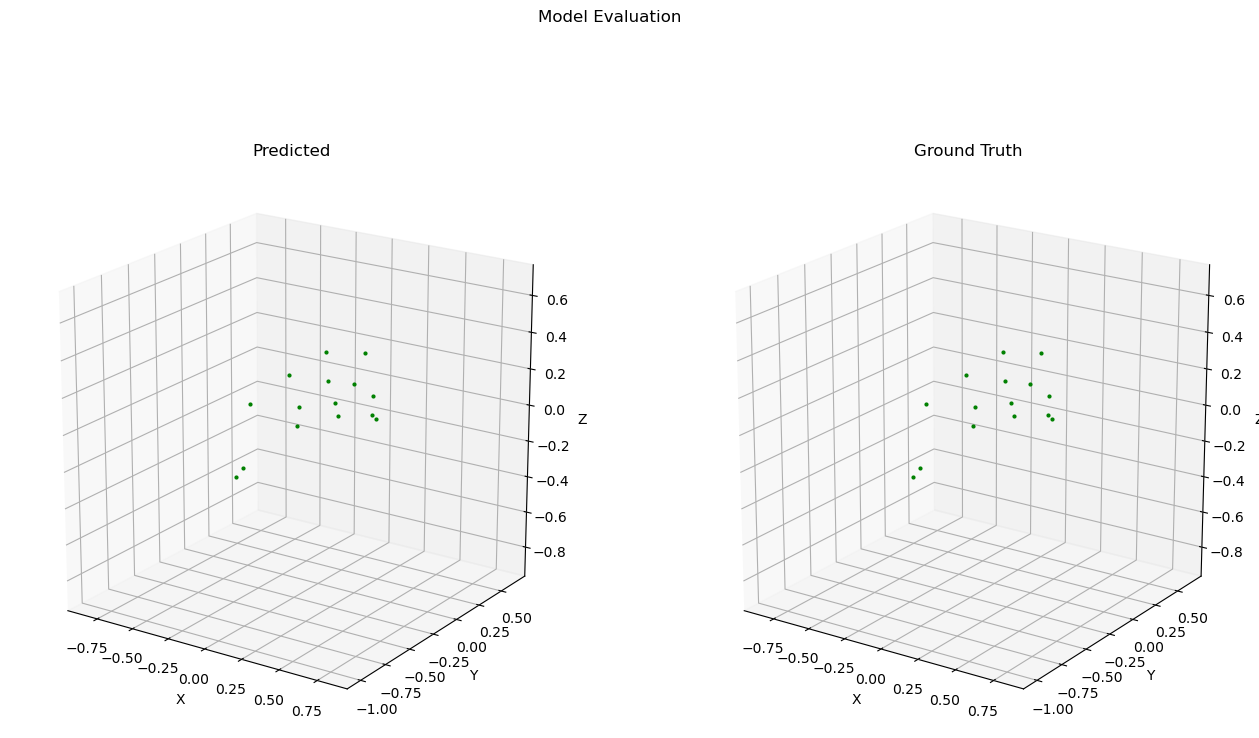

Evaluation finished!


In [32]:
# Run name
experiment_name = 'final_models'
run_name = 'model_nonorm'
checkpoint_name = 80
# Visualization parameters
VISUALIZATION_TYPE = ['3d']
VISUALIZATION_PREDICTION_TIMESTEPS = [80, 120, 160, 200, 240, 280, 320, 360, 400, 440, 480, 520, 560]
INTERACTIVE = False
OVERLAY = True
SPLIT_ACTIONS = False
NUM_VISUALIZATIONS = 1
RANDOM_SEED = 45
# Run the visualization
# Initialize session
session = Session(
    experiment_name=experiment_name,
    run_name=run_name,
    log_process_external=False,
    num_threads=2,
    debug=False
)
# Initialize the model
session.initialize_model()
# Load the checkpoint
session.load_checkpoint(checkpoint_name)
# Initialize the visualization
session.initialize_visualization(
                                    visualization_type = VISUALIZATION_TYPE,
                                    prediction_timesteps=VISUALIZATION_PREDICTION_TIMESTEPS,
                                    dataset = 'h36m',
                                    interactive=INTERACTIVE,
                                    overlay_visualization=OVERLAY,
                                    split_actions=SPLIT_ACTIONS,
                                    )
# Visualize the model's predictions
session.visualize(NUM_VISUALIZATIONS)
# 2d Visualizations are stored in session
if '2d' in VISUALIZATION_TYPE:
    # Show each visualization
    for i in range(NUM_VISUALIZATIONS):
        # Get the visualization
        visualization = session.evaluation_engine.vis2d_figures[i]
        # Show the visualization
        display(visualization)

### Global Predictions <a class="anchor" id="h36m_global"></a>

#### Quantitative Results

In [ ]:
# Run name
experiment_name = 'final_models'
run_name = 'model_global_2'
checkpoint_name = 80
# Evaluation parameters
DISTANCE_METRICS = ['positional_mse', 'auc']
DISTRIBUTION_METRICS = ['ps_entropy', 'ps_kld', 'npss']
DISTANCE_PREDICTION_TIMESTEPS = [80, 120, 160, 200, 240, 280, 320, 360, 400, 440, 480, 520, 560]
# Run the evaluation
# Initialize session
session = Session(
    experiment_name=experiment_name,
    run_name=run_name,
    log_process_external=False,
    num_threads=2,
    debug=False
)
# Initialize the model
session.initialize_model()
# Load the checkpoint
session.load_checkpoint(checkpoint_name)
# Initialize the evaluation
session.initialize_evaluation(
                                evaluation_type = ['distance'],
                                num_iterations=1000,
                                distance_metrics=DISTANCE_METRICS,
                                split_actions=False,
                                prediction_timesteps=DISTANCE_PREDICTION_TIMESTEPS,
                                dataset = 'h36m',
                                )
# Evaluate the model
session.evaluate()
# Print the evaluation results
session.evaluation_engine.print()

#### Qualitative Results

## AIS Dataset Evaluation <a class="anchor" id="ais_eval"></a>

## Long Prediction Evaluation <a class="anchor" id="long_pred"></a>